In [2]:
#pip install facenet_pytorch

In [3]:
import os           

# Check if string is appropriate youtube link
import re
import cv2
import numpy as np
import pandas as pd
from facenet_pytorch import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from pytube import YouTube

import face_recognition

import seaborn as sns
import plotly.express as px

SAVE_VIDEO = True
SHOW_PROMPT = False

# DEBUG-Mode stops operations when max_emotions were detected and also prints a short summary
DEBUG = True
if DEBUG:
    import time
    debug_params = {
        'max_emotions' : 100
    }

In [4]:
def get_path(kind):
    if kind == "youtube":
        return "https://www.youtube.com/watch?v=vtT78TfDfXU"                   # Random video
        #return 'https://www.youtube.com/watch?v=embYkODkzcs'                 # 7 basic emotions
        #return 'https://www.youtube.com/watch?v=m70UInZKJjU'                    # Two persons
    if kind == "local":
        # adjust individually
        return '/Users/steve/Neue_Fische/face_demo/vids/Video_One_output.mp4'
    if kind == "error_on_purpose":
        return "wrongful path"
    else:
        raise ValueError(f"Passed Argument kind must bei in ['youtube', 'local', 'error_on_purpose'] but was: {kind}")

def youtube_stream(yt_link):
    # Load the video from YouTube
    yt_video = YouTube(yt_link)
    stream = yt_video.streams.get_highest_resolution()    #or highest resolution?
    stream.download()
    return cv2.VideoCapture(stream.default_filename)

def local_stream(local_path):
    return cv2.VideoCapture(local_path)

def get_stream(path):
    # Check if the string is a YouTube link
    if re.match(r'(https?://)?(www\.)?(youtube\.com|youtu\.?be)/.+$', path):
        return youtube_stream(path)
    # Check if the string is a local path
    elif os.path.isfile(path):
        return local_stream(path)
    # Check if the path is a local file path but no file is found
    elif os.path.exists(path):
        raise ValueError(f"File not found at path: {path}")
    # If it's neither a local path nor a YouTube link, raise an error
    else:
        raise ValueError("The input string is neither a local path nor a YouTube link.")
    
def load_emotion_classifier():
    return load_model("../models/emotion_model.hdf5", compile=False)

def preprocess_face(face, input_face_size):
    face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)  # Convert the face to grayscale
    face = cv2.resize(face, (input_face_size[1], input_face_size[0]))  # Swap width and height
    face = face.astype('float32') / 255.0
    face = np.expand_dims(face, axis=-1)  # Add an additional dimension for grayscale channel
    face = np.expand_dims(face, axis=0)
    return face

def print_debug_report(operating_results):    
    print(f'{operating_results["analyzed_emotions"]} faces found in {operating_results["analyzed_frames"]} frames.')
    print(f'{operating_results["frames_without_faces"]} frames had no face detected ({operating_results["frames_without_faces_ratio"]}%).')
    print(f'Stopped operations after around {operating_results["processed_video_time"]} seconds into the video.')
    print(f'Execution time: {operating_results["runtime"]} seconds, processing (roughly) {round(operating_results["processed_video_time"]/operating_results["runtime"],2)} seconds of video per second of execution')

def initialize_face_detector(model_type):
    if model_type == 'haarcascade':
        return cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    elif model_type == "MTCNN":
        return MTCNN(keep_all=True, post_process=False, margin=20)
    else:
        raise ValueError("By now, only Haarcascade is implemented.")

def preprocess_frame_for_face_detection_haarcascade(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

def preprocess_frame_for_emotion_detection(frame):
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

def normalize_boxes_mtcnn(boxes):
    """
    Normalize the bounding box coordinates from MTCNN to numpy indexing format.
    Output format: np.array(y_min, y_max, x_min, x_max)
    """
    normalized_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box.astype(int)
        normalized_boxes.append([y_min, y_max, x_min, x_max])
    return np.array(normalized_boxes)

def normalize_boxes_cv2(boxes):
    """
    Normalize the bounding box coordinates from OpenCV's format to numpy indexing format.
    Output format: np.array(y_min, y_max, x_min, x_max)
    """
    normalized_boxes = []
    for box in boxes:
        x, y, w, h = box
        normalized_boxes.append([y, y+h, x, x+w])
    return np.array(normalized_boxes)

def detect_faces(frame, face_detector, model_type = 'haarcascade'):
    if model_type == 'haarcascade':
        frame_pp = preprocess_frame_for_face_detection_haarcascade(frame)
        boxes =  face_detector.detectMultiScale(frame_pp, scaleFactor = 1.3, minNeighbors = 3)
        if boxes is None:
            return None
        else:
            return normalize_boxes_cv2(boxes)
    elif model_type == "MTCNN":
        # No preprocessing needed for VideoCapture Frame
        boxes, _ = face_detector.detect(frame)
        if boxes is None:
            return None
        else:
            return normalize_boxes_mtcnn(boxes)
        #return [(x['box'][1], x['box'][0] + x['box'][2], x['box'][1] + x['box'][3], x['box'][0]) for x in bounding_boxes]
    #elif model_type == "fast_MTCNN"
    # https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49
    else:
        raise ValueError("By now, only Haarcascade is implemented.")
    
def get_ordered_emotions():
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def emotions_probability(frame, face_location, emotion_classifier):
    frame_pp = preprocess_frame_for_emotion_detection(frame)
    y_min, y_max, x_min, x_max = face_location
    face = frame_pp[y_min:y_max, x_min:x_max]
    face = preprocess_face(face, input_face_size=emotion_classifier.input_shape[1:3])
    prob = emotion_classifier.predict(face)[0]  # check for underscore
    return prob

def output_video(video, filename):
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    return cv2.VideoWriter(filename, fourcc, 10, (width,height))

def get_overview_df(emotions, frame_info, frame_info_cols):
    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    return df_all_info

def get_plottable_df(emotions, frame_info, frame_info_cols):

    assert len(frame_info[0]) == len(frame_info_cols), \
        f"Number of columns in frame_info and number of passed names in frame_info_cols is not the same: {len(frame_info[0])} != {len(frame_info_cols)}."

    df_emotions = pd.DataFrame(emotions, columns=get_ordered_emotions())
    df_frame_info = pd.DataFrame(frame_info, columns=frame_info_cols)
    df_all_info = pd.concat([df_emotions, df_frame_info], axis=1)
    df_plotting = pd.melt(df_all_info, id_vars=frame_info_cols, value_vars=get_ordered_emotions(), var_name='emotion', value_name='probability')
    return df_plotting

In [5]:
if DEBUG: start_time = time.time()

# Define video path
path = get_path('youtube')

# Set the number of frames to skip
frames_to_skip = 1

# Get Video as cv2.VideoCapture
# Can access Youtube Video or local file
video = get_stream(path)

# Initialize writer to save the annotated video
if SAVE_VIDEO: writer = output_video(video, filename='outputs/Output_video.mp4')

# Initialize the face detection model
#model_type = "MTCNN"
model_type = "haarcascade"
face_detector = initialize_face_detector(model_type)


# Initialize the emotion detection model
emotion_classifier = load_emotion_classifier()

# Initialize lists to store emotions and frame_info
emotions = []
frame_info = []

# Initialize counters
frames_without_faces_counter = 0
individual_id_counter = 0
face_embeddings = {}


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
2023-03-24 13:05:24.517047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-24 13:05:24.517446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [6]:
# Loop through each frame of the video
while True:

    # Read the next frame from the video
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Increment the frame counter
    current_frame_nr = int(video.get(cv2.CAP_PROP_POS_FRAMES))

    # Skip frames based on the frames_to_skip parameter
    if current_frame_nr % frames_to_skip != 0:
        continue
    
    # Find faces within a frame and return list of coordinates of bounding boxes
    face_locations = detect_faces(frame, face_detector, model_type)

    # Check if any faces were found
    if face_locations is None:
        frames_without_faces_counter += 1
        continue

    for i, face_location in enumerate(face_locations):
        prob = emotions_probability(frame, face_location, emotion_classifier)
        emotions.append(prob)
        
        # Add the current timestamp (milliseconds) and probabilities of emotions to the frame_description list
        # current implementation to prepare for tuple-wise operation, change frame later to character_nr
        
        frame_info.append(
            (round(video.get(cv2.CAP_PROP_POS_MSEC) / 1000, 2),
                current_frame_nr
                )
        )    

        max_emotion, max_prob = np.argmax(prob), np.max(prob)
        emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
        emotion_text = emotion_labels[max_emotion]

        for (y_min, y_max, x_min, x_max) in face_locations:
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(frame, f"Prob: {max_prob:.1%}", (x_min, y_max + 60), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
            cv2.putText(frame, f"{emotion_text}", (x_min, y_max + 30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
            cv2.putText(frame, f"Frame {current_frame_nr}", (30,40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 1)
            
    if SAVE_VIDEO: writer.write(frame)
    
    if SHOW_PROMPT:
        cv2.imshow("Faces found", frame)

        # Wait for Esc key to stop
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

    if DEBUG:
        # For debugging reasons, we stop when we have 1000 emotion values
        if len(emotions) > debug_params['max_emotions']:
            break

# Release the video and close the window
video.release()

if SAVE_VIDEO: writer.release()

# De-allocate any associated memory usage
cv2.destroyAllWindows()

if DEBUG: end_time = time.time()

if DEBUG:
    # When in DEBUG-mode, print some statistics about the faces and emotions detected
    operating_results = {'analyzed_emotions': len(emotions),
                         'analyzed_frames':frame_info[-1][1], 
                         'frames_without_faces':frames_without_faces_counter,
                         'frames_without_faces_ratio': round(100*frames_without_faces_counter/frame_info[-1][1],2),
                         'processed_video_time': round(frame_info[-1][0] / 1000 ,2),
                         'runtime': round(end_time - start_time,2)}
    
    print_debug_report(operating_results)
    
df_plotting = get_plottable_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

2023-03-24 13:05:24.903858: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-24 13:05:25.020067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


101 faces found in 102 frames.
0 frames had no face detected (0.0%).
Stopped operations after around 0.0 seconds into the video.
Execution time: 9.71 seconds, processing (roughly) 0.0 seconds of video per second of execution


In [7]:
df_plotting

,pos_sec,frame,emotion,probability
0,0.00,1,Angry,0.004754
1,0.04,2,Angry,0.006010
2,0.08,3,Angry,0.003043
3,0.12,4,Angry,0.005749
4,0.17,5,Angry,0.004518
...,...,...,...,...
702,4.04,98,Neutral,0.076397
703,4.08,99,Neutral,0.054596
704,4.12,100,Neutral,0.041396
705,4.17,101,Neutral,0.034057


In [8]:
"""
        face_landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]
    for i, face_landmark in enumerate(face_landmarks):
        if not face_landmark:
            continue

        if i < len(face_locations):
            face_encoding = face_recognition.face_encodings(rgb_frame, [face_locations[i]])[0]
        else:
            continue            
        current_individual_ids = []

        # Compare the current face encoding with the existing face embeddings
        for individual_id, individual_face_encoding in face_embeddings.items():
            if face_recognition.compare_faces([individual_face_encoding], face_encoding)[0]:
                current_individual_ids.append(individual_id)
                break
        else:
            individual_id_counter += 1
            current_individual_ids.append(individual_id_counter)
            face_embeddings[individual_id_counter] = face_encoding
    """

'\n        face_landmarks = face_recognition.face_landmarks(rgb_frame, [face_location])[0]\n    for i, face_landmark in enumerate(face_landmarks):\n        if not face_landmark:\n            continue\n\n        if i < len(face_locations):\n            face_encoding = face_recognition.face_encodings(rgb_frame, [face_locations[i]])[0]\n        else:\n            continue            \n        current_individual_ids = []\n\n        # Compare the current face encoding with the existing face embeddings\n        for individual_id, individual_face_encoding in face_embeddings.items():\n            if face_recognition.compare_faces([individual_face_encoding], face_encoding)[0]:\n                current_individual_ids.append(individual_id)\n                break\n        else:\n            individual_id_counter += 1\n            current_individual_ids.append(individual_id_counter)\n            face_embeddings[individual_id_counter] = face_encoding\n    '

In [9]:
df_overview  = get_overview_df(emotions, frame_info, frame_info_cols=['pos_sec', 'frame'])

In [10]:
df_overview.head(30)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame
0,0.004754,1.568966e-05,0.006978,0.937312,0.003946,0.004224,0.042770,0.00,1
1,0.006010,1.628348e-05,0.027883,0.762690,0.009061,0.012228,0.182112,0.04,2
2,0.003043,1.090113e-05,0.014361,0.899901,0.004817,0.005181,0.072687,0.08,3
3,0.005749,4.555533e-05,0.030709,0.862432,0.006436,0.016714,0.077915,0.12,4
4,0.004518,2.951487e-05,0.025148,0.852247,0.008460,0.004969,0.104629,0.17,5
5,0.014398,1.086464e-04,0.064432,0.770944,0.033075,0.010573,0.106470,0.21,6
6,0.003394,1.460315e-05,0.008064,0.937469,0.002114,0.002497,0.046448,0.25,7
7,0.022420,8.548751e-05,0.058179,0.734867,0.018430,0.010781,0.155238,0.29,8
8,0.015442,2.231497e-05,0.098677,0.804541,0.007662,0.023076,0.050580,0.33,9
9,0.005769,1.211875e-05,0.048737,0.869642,0.006872,0.006617,0.062350,0.38,10


In [11]:
len(face_locations)

1

In [12]:
face_locations

array([[ 34, 390, 506, 862]], dtype=int32)

In [13]:
df_overview.head(50)

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral,pos_sec,frame
0,0.004754,1.568966e-05,0.006978,0.937312,0.003946,0.004224,0.042770,0.00,1
1,0.006010,1.628348e-05,0.027883,0.762690,0.009061,0.012228,0.182112,0.04,2
2,0.003043,1.090113e-05,0.014361,0.899901,0.004817,0.005181,0.072687,0.08,3
3,0.005749,4.555533e-05,0.030709,0.862432,0.006436,0.016714,0.077915,0.12,4
4,0.004518,2.951487e-05,0.025148,0.852247,0.008460,0.004969,0.104629,0.17,5
5,0.014398,1.086464e-04,0.064432,0.770944,0.033075,0.010573,0.106470,0.21,6
6,0.003394,1.460315e-05,0.008064,0.937469,0.002114,0.002497,0.046448,0.25,7
7,0.022420,8.548751e-05,0.058179,0.734867,0.018430,0.010781,0.155238,0.29,8
8,0.015442,2.231497e-05,0.098677,0.804541,0.007662,0.023076,0.050580,0.33,9
9,0.005769,1.211875e-05,0.048737,0.869642,0.006872,0.006617,0.062350,0.38,10


# Change Colours of emotions according to your likings

In [14]:
#defining function
def update_cb_palette(emotion_colors):
    """
    Updates a color palette with the specified colors for each emotion.

    Parameters:
    - emotion_colors (dict): a dictionary mapping emotions to color codes (e.g. {'Neutral': '#CA3435', 'Happy': '#00ff00'})
    - default_palette (list, optional): a list of color codes to use as the default palette. 
    If not specified, the default is ['#CA3435', '#ff7f00', '#9370DB', '#40E0D0', '#1f77b4', '#9467bd', '#7f7f7f'].

    Returns:
    - a modified color palette with the specified colors for each emotion.
    """
    # Define the default color palette
    default_palette = ['#CA3435', '#ff7f00', '#9370DB', '#40E0D0', '#1f77b4', '#9467bd', '#7f7f7f']

    # Create a copy of the default palette to modify
    new_palette = default_palette.copy()

    # Update the color of each emotion in the new palette
    for emotion, color in emotion_colors.items():
        if emotion in ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprise', 'Fear', 'Disgust']:
            index = ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprise', 'Fear', 'Disgust'].index(emotion)
            new_palette[index] = color

    return new_palette



In [15]:
# Define a dictionary with the desired color for each emotion
emotion_colors = {'Neutral': '#CA3435', 'Happy': '#00ff00', 'Sad': '#0000ff', 'Angry': '#ff0000',
                  'Surprise': '#ffff00', 'Fear': '#800080', 'Disgust': '#ffa500'}

# Update the color palette
cb_palette = update_cb_palette(emotion_colors)

# Create plot with updated color palette
fig = px.bar(df_plotting, x="pos_sec", y='probability', color='emotion',
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)",
             color_discrete_sequence=cb_palette)

# Update legend and adjust title position
fig.update_layout(coloraxis_colorbar=dict(
    title="Emotion",
    tickvals=[0, 1, 2, 3, 4, 5, 6],
    ticktext=["Neutral", "Happy", "Sad", "Angry", "Surprise", "Fear", "Disgust"],
    tickmode="array",
    tickfont=dict(color="black", size=12)
))
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",
                  title={'y': 0.95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'})
fig.show(height=500, width=800)

# Plots

In [16]:
#df_10th = df_plotting[df_plotting["frame"] % 3 == 0]  # select every 10th frame

fig = px.bar(df_plotting, x="pos_sec", y='probability', color = 'emotion',
             barmode="stack", title="Distribution of Emotions across Frames (every 10th frame)")
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",     title={
        'y': 0.9,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })
fig.show()

In [17]:
#New

# Define a colorblind-friendly color palette
cb_palette = ['#CA3435', '#ff7f00', '#9370DB', '#40E0D0', '#1f77b4', '#9467bd', '#7f7f7f']
#CA3435
# Create plot
fig = px.bar(df_plotting, x="pos_sec", y='probability', color='emotion',
             barmode="stack", title="<b>Distribution of Emotions across Frames (every 10th frame)</b>",
             color_discrete_sequence=cb_palette)

# Add axis labels to the legend and text labels for the colors
fig.update_layout(coloraxis_colorbar=dict(
    title="Emotion",
    tickvals=[0, 1, 2, 3, 4, 5, 6],
    ticktext=["Neutral", "Happy", "Sad", "Angry", "Surprise", "Fear", "Disgust"],
    tickmode="array",
    tickfont=dict(color="black", size=12)
))

# Add axis labels and adjust title position
fig.update_layout(xaxis_title="Frame", yaxis_title="Emotion Distribution",
    title={
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    })

# Adjust plot size
fig.show(height=500, width=800)


In [18]:
#df_10th = df_emotions[df_emotions["Frame"] % 20 == 0]  # select every 10th frame

# assuming your DataFrame is named df
fig = px.area(df_plotting, x="pos_sec", y='probability', color = 'emotion',
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion-Map")

fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    yaxis=dict(
        title='Emotion distribution'
    ),
    xaxis=dict(
        title='Frame'
    ),
    title={
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)

fig.show()

In [19]:
#New

# Create plot
fig = px.area(df_plotting, x="pos_sec", y='probability', color='emotion',
              color_discrete_sequence=px.colors.sequential.Viridis, title="Emotion Distribution over Time")

fig.update_layout(
    plot_bgcolor='white',  # set the plot background color
    legend_title_text='Emotion',  # set the legend title text
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        title_font=dict(size=14),
        font=dict(size=12)
    ),
    xaxis=dict(
        title='Frames',
        showgrid=False,  # remove the x-axis grid lines
        linecolor='black',  # set the x-axis line color
        linewidth=1,  # set the x-axis line width
        mirror=True  # reflect the x-axis labels and ticks
    ),
    yaxis=dict(
        title='Emotion Probability',
        showgrid=False,  # remove the y-axis grid lines
        linecolor='black',  # set the y-axis line color
        linewidth=1,  # set the y-axis line width
        mirror=True  # reflect the y-axis labels and ticks
    ),
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=80,
        pad=4
    ),
    title={
        'text': '<b>Emotion Distribution over Frames</b>',  # set the title text and make it bold
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(size=20)  # set the title font size
    }
)

fig.show()

<Axes: xlabel='pos_sec', ylabel='probability'>

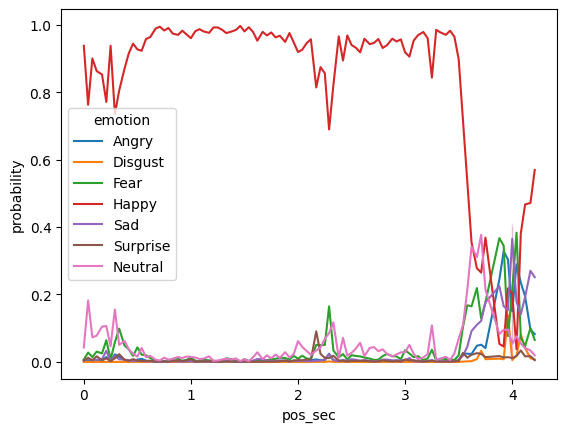

In [20]:
sns.lineplot(data = df_plotting, x = 'pos_sec', y='probability', hue = 'emotion')

In [21]:
#New

# set the color palette using the cb_palette list
cb_palette = ['#CA3435', '#ff7f00', '#9370DB', '#40E0D0', '#1f77b4', '#9467bd', '#7f7f7f']

fig = px.line(
    data_frame=df_plotting,
    x='pos_sec',
    y='probability',
    color='emotion',
    color_discrete_sequence=cb_palette  # use the specified color palette
)

# Change the layout
fig.update_layout(
    title={
        'text': "<b>Probability of emotion per frame</b>",
        'font': {'size': 24, 'family': 'Arial', 'color': 'black'},
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)



fig.show()




In [22]:
fig = px.area(df_plotting, x="pos_sec", y="probability", color="emotion")
fig.show()

In [23]:
#New

# Define the color palette
cb_palette = ['#CA3435', '#ff7f00', '#9370DB', '#40E0D0', '#1f77b4', '#9467bd', '#7f7f7f']

# Create the plot 
fig = px.area(df_plotting, x="pos_sec", y="probability", color="emotion",
              color_discrete_sequence=cb_palette, hover_data={"text": df_plotting['emotion']})

# Update the layout 
fig.update_layout(
    title={
        'text': '<b>Probability of emotion per frame</b>',
        'font': {'size': 24, 'color': 'black'},
        'x': 0.5, #center header
        'y': 0.95 #center header
    },
    xaxis_title='Frames',
    yaxis_title='Probability',
    legend_title='Emotion',
    font=dict(family='Arial', size=14),
    margin=dict(l=50, r=50, t=100, b=50),
    plot_bgcolor='white',
    xaxis=dict(dtick=1)  #set the x-axis step 
)

# Update the legend with customizations
fig.update_traces(
    hovertemplate='<br>'.join([
        'Emotion: %{fullData.name}',
        'Frame: %{x:.2f} ',
        'Probability: %{y:.2f}'
    ]),
    hoverlabel=dict(bgcolor='white', font_size=14),
    line=dict(width=2),
    showlegend=True,
    stackgroup='one',
    hoverinfo='all'
)

fig.show()


In [24]:
df = df_plotting
df['moving_avg'] = df['probability'].rolling(window=10, center=True).mean()

In [25]:
fig = px.area(df, x="pos_sec", y="moving_avg", color="emotion")
fig.show()

In [26]:
#New

# Define palette 
cb_palette = ['#CA3435', '#ff7f00', '#9370DB', '#40E0D0', '#1f77b4', '#9467bd', '#7f7f7f']

# Create the plot 
fig = px.area(df, x="pos_sec", y="moving_avg", color="emotion",
              color_discrete_sequence=cb_palette, hover_data={"text": df['emotion']})

# Update the layout 
fig.update_layout(
    title={
        'text': '<b>Moving Average of Emotion Probability</b>',
        'font': {'size': 24, 'color': 'black'},
        'x': 0.5,
        'y': 0.9,
        'yanchor': 'middle'
    },
    xaxis_title='Time (seconds)',
    yaxis_title='Moving Average Probability',
    legend_title='Emotion',
    font=dict(family='Arial', size=14),
    margin=dict(l=50, r=50, t=100, b=50),
    plot_bgcolor='white'
)

# Update the legend with customizations
fig.update_traces(
    hovertemplate='<br>'.join([
        'Emotion: %{fullData.name}',
        'Time: %{x:.2f} s',
        'Moving Avg Probability: %{y:.2f}'
    ]),
    hoverlabel=dict(bgcolor='white', font_size=14),
    line=dict(width=2),
    showlegend=True,
    stackgroup='one',
    hoverinfo='all'
)

fig.show()


# I Adjusted plots until here

### Still Open
* Periods with no people are by now interlinked - so we have straight in the original data and valleys forming in the rolling mean.
* Tha Barcharts show quite well when multiple people com into play - but by now, their values are summed up. If we can get Character Recognition to work, that will be great - if not, at least we can try to reduce it down to one person per frame, but there's no guarantee that we always get the same person.
* With objects and classes we could structure the code even better
* I have the feeling from my videos that the performance is not super good right - maybe we achieve to get better results somehow.
* Much faster on youtube video data looking at Video_seconds analyzed per processing second.

#### After Dinner the youtube integration stopped working, I can't see why!

In [27]:
df_plotting.head()

,pos_sec,frame,emotion,probability,moving_avg
0,0.00,1,Angry,0.004754,NaN
1,0.04,2,Angry,0.006010,NaN
2,0.08,3,Angry,0.003043,NaN
3,0.12,4,Angry,0.005749,NaN
4,0.17,5,Angry,0.004518,NaN


<Axes: xlabel='frame', ylabel='moving_avg'>

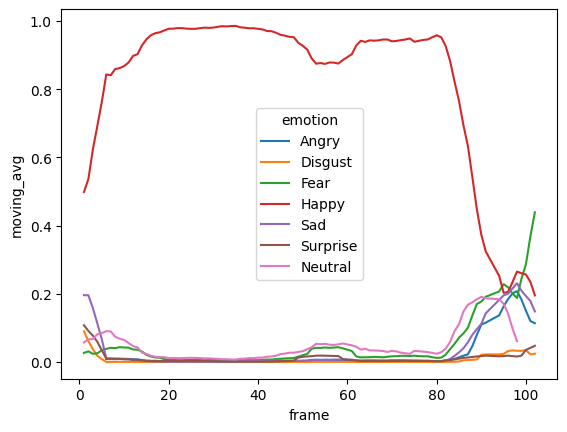

In [28]:
sns.lineplot(data = df_plotting, x = 'frame', y='moving_avg', hue = 'emotion')

In [29]:
df_plotting

,pos_sec,frame,emotion,probability,moving_avg
0,0.00,1,Angry,0.004754,NaN
1,0.04,2,Angry,0.006010,NaN
2,0.08,3,Angry,0.003043,NaN
3,0.12,4,Angry,0.005749,NaN
4,0.17,5,Angry,0.004518,NaN
...,...,...,...,...,...
702,4.04,98,Neutral,0.076397,0.060849
703,4.08,99,Neutral,0.054596,NaN
704,4.12,100,Neutral,0.041396,NaN
705,4.17,101,Neutral,0.034057,NaN


In [30]:
max_prob_rows = df_plotting.groupby('frame')['probability'].idxmax().reset_index()
max_prob_df = df.loc[max_prob_rows['probability']]
feeling_counts = max_prob_df.groupby('emotion')['frame'].nunique()
max_prob_df


,pos_sec,frame,emotion,probability,moving_avg
303,0.00,1,Happy,0.937312,0.498270
304,0.04,2,Happy,0.762690,0.537043
305,0.08,3,Happy,0.899901,0.623552
306,0.12,4,Happy,0.862432,0.692381
307,0.17,5,Happy,0.852247,0.762766
...,...,...,...,...,...
298,4.04,98,Fear,0.383211,0.187630
400,4.08,99,Happy,0.380906,0.259919
401,4.12,100,Happy,0.466949,0.256263
402,4.17,101,Happy,0.471336,0.234925


<Axes: xlabel='frame', ylabel='probability'>

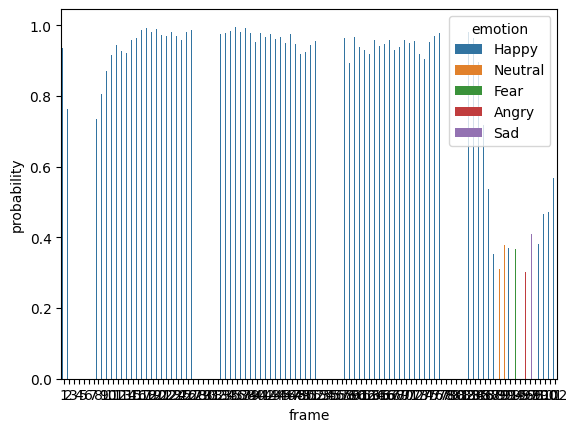

In [31]:
sns.barplot(data = max_prob_df, x = 'frame', y='probability', hue='emotion')

In [32]:
#New

# Define palette 
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']
#CA3435
# Create the bar plot
fig = px.bar(max_prob_df, x='frame', y='probability', color='emotion', 
             color_discrete_sequence=cb_palette, hover_data={"text": max_prob_df['emotion']})

# Update the layout
fig.update_layout(   
    title={
        'text': '<b>Maximum Probability of Emotion per Frame</b>',
        'font': {'size': 24, 'color': 'black'},
        'x': 0.5,
        'y': 0.9,
        'yanchor': 'middle'
    },
    xaxis_title='Frame',
    yaxis_title='Probability',
    legend_title='Emotion',
    font=dict(family='Arial', size=14),
    margin=dict(l=50, r=50, t=100, b=50),
    plot_bgcolor='white'
)

# Update the legend with customizations
fig.update_traces(
    hovertemplate='<br>'.join([
        'Emotion: %{fullData.name}',
        'Frame: %{x}',
        'Probability: %{y:.2f}'
    ]),
    hoverlabel=dict(bgcolor='white', font_size=14),
    showlegend=True,
    hoverinfo='all'
)

# Show the plot
fig.show()


In [33]:
'''
# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# group by feeling and count unique frames
feeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()

# print top three probabilities for each frame
print(top_three_probs)
'''

"\n# sort dataframe by probability within each frame\nsorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])\n\n# get the top three probabilities for each frame\ntop_three_probs = sorted_df.groupby('frame').head(3)\n\n# group by feeling and count unique frames\nfeeling_counts = top_three_probs.groupby('feeling')['frame'].nunique()\n\n# print top three probabilities for each frame\nprint(top_three_probs)\n"

In [34]:

# sort dataframe by probability within each frame
sorted_df = df.sort_values(['frame', 'probability'], ascending=[True, False])

# get the top three probabilities for each frame
top_three_probs = sorted_df.groupby('frame').head(3)

# count the number of occurrences of each feeling for each frame
feeling_counts = top_three_probs.groupby(['frame', 'emotion'])['probability'].count().reset_index()

# calculate the total probability for each frame
frame_total = feeling_counts.groupby('frame')['probability'].sum().reset_index()

# merge the feeling counts and frame totals dataframes
merged = pd.merge(feeling_counts, frame_total, on='frame', suffixes=('_count', '_total'))

# calculate the normalized distribution of each feeling for each frame
merged['probability_normalized'] = merged['probability_count'] / merged['probability_total']

# create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='frame', 
    y='probability_normalized', 
    color='emotion', 
    color_discrete_sequence=px.colors.qualitative.Plotly,
    title='Normalized Emotion Distribution',
    labels={
        'Frame': 'Frame',
        'probability_normalized': 'Probability',
        'feeling': 'Feeling'
    }
)

fig.show()


In [35]:
#New

# Define palette 
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create a stacked area chart using Plotly
fig = px.area(
    merged, 
    x='frame', 
    y='probability_normalized', 
    color='emotion', 
    color_discrete_sequence=cb_palette,
    labels={
        'frame': 'Frame',
        'probability_normalized': 'Normalized Probability',
        'emotion': 'Emotion'
    },
    hover_data={
        'probability_count': ':.2f',
        'probability_total': False
    },
    template='simple_white'
)

# Customize the chart layout
fig.update_traces(mode='lines+markers', hovertemplate=None)
fig.update_layout(
    title={
        'text': '<b>Normalized Emotion Distribution</b>',
        'y': 0.97,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    legend=dict(title='Emotion', orientation='h', y=1.1),
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=50,
        tickfont=dict(size=12),
        hoverformat=None
    )
)

fig.show()





In [36]:
import plotly.graph_objs as go

# group the dataframe by feeling and count the number of unique frames for each feeling
feeling_counts = max_prob_df.groupby('emotion')['frame'].nunique()

# create a bar chart with the feeling counts
data = go.Bar(x=feeling_counts.index, y=feeling_counts.values)

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings')

# create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [37]:
# New

# Create a bar chart to show the prevalence of different emotions
fig = go.Figure(go.Bar(x=feeling_counts.index, y=feeling_counts.values, marker=dict(color='#1f77b4')))

# Update the chart layout with a bold, centered title and a darker, softer blue color
fig.update_layout(title={'text': '<b>Prevalence of Emotions</b>', 'x':0.5, 'y':0.95},
                  xaxis_title='Emotions', yaxis_title='Counts',
                  showlegend=False)

# Show the chart
fig.show()




In [38]:
# create the data for the outer and inner rings
outer_data = go.Pie(labels=feeling_counts.index, values=feeling_counts.values, hole=0.45)
inner_data = go.Pie(labels=[''], values=[1], hole=1, marker=dict(colors=['white']))

# create the layout for the chart
layout = go.Layout(title='Prevalence of feelings', annotations=[{
            'text': 'Total frames: {}'.format(len(max_prob_df)),
            'font': {'size': 20},
            'showarrow': False,
            'x': 0.5,
            'y': 0.5
        }])

# create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()

In [39]:
# New

# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create the data for the outer and inner rings of the pie chart
outer_data = go.Pie(
    labels=feeling_counts.index,
    values=feeling_counts.values,
    hole=0.45,
    marker=dict(colors=cb_palette),
    name='Feeling Prevalence'  # add a name for the legend
)

inner_data = go.Pie(
    labels=[''],
    values=[1],
    hole=1,
    marker=dict(colors=['white'])
)

# Create the layout for the chart
layout = go.Layout(
    title=dict(
        text='<b>Prevalence of Feelings</b>',
        font=dict(size=20),
        x=0.5,  # set x to center the title
        y=0.9   # set y to place it in the middle of the top
    ),
    annotations=[
        dict(
            text=f'Total Frames: {len(max_prob_df)}',
            font=dict(size=20),
            showarrow=False,
            x=0.5,
            y=0.5
        )
    ],
    font=dict(color='#555', size=12),
    showlegend=True  # show the legend
)

# Create the figure object and display the chart
fig = go.Figure(data=[outer_data, inner_data], layout=layout)
fig.show()







In [40]:
feeling_counts.values

array([ 1,  3, 93,  2,  1])

In [41]:
feeling_counts

emotion
Angry       1
Fear        3
Happy      93
Neutral     2
Sad         1
Name: frame, dtype: int64

In [42]:
categories = ["angry",
            "disgust",
            "fear",
            "happy",
            "sad",
            "surprise",
            "neutral"]
#values = [max_prob_df[max_prob_df['feeling'] == category]['frame'].nunique() for category in categories]

# Define the categories and values
#categories = feeling_counts.index
values = feeling_counts.values

# Create the radar chart
data = go.Scatterpolar(
    r = values,
    theta = categories,
    fill = 'toself',
    name = 'Prevalence of feelings'
)

# Set the layout for the chart
layout = go.Layout(
    polar = dict(
        radialaxis = dict(
            visible = False,
            range = [0, max(values)]
        )
    ),
    showlegend = False,
    title = 'Prevalence of feelings'
)

# Create the figure object and display the chart
fig = go.Figure(data=[data], layout=layout)
fig.show()

In [43]:
df_plotting

,pos_sec,frame,emotion,probability,moving_avg
0,0.00,1,Angry,0.004754,NaN
1,0.04,2,Angry,0.006010,NaN
2,0.08,3,Angry,0.003043,NaN
3,0.12,4,Angry,0.005749,NaN
4,0.17,5,Angry,0.004518,NaN
...,...,...,...,...,...
702,4.04,98,Neutral,0.076397,0.060849
703,4.08,99,Neutral,0.054596,NaN
704,4.12,100,Neutral,0.041396,NaN
705,4.17,101,Neutral,0.034057,NaN


In [44]:
#New

# Define a function that returns the emotion with the highest probability for a given row
def get_max_emotion(row):
    return row['emotion'][np.argmax(row['probability'])]

# Apply the function to each row of the DataFrame
max_emotions = df_plotting.apply(get_max_emotion, axis=1)

# max_emotions will be a pandas Series object containing the emotion with the highest probability for each row of the DataFrame

#counts the number of emotions
emotions_counts = max_prob_df['emotion'].value_counts().reset_index()



In [45]:
# Rename the columns
emotions_counts = emotions_counts.rename(columns={'': 'Index', 'index': 'emotion', 'emotion': 'count'})

emotions_counts

,emotion,count
0,Happy,93
1,Fear,3
2,Neutral,2
3,Angry,1
4,Sad,1


In [46]:
# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']
# create the plot
fig = go.Figure(data=go.Scatterpolar(
    r=emotions_counts['count'].tolist(),
    theta=emotions_counts['emotion'].tolist(),
    fill='toself',
    name='',
    line_color=cb_palette[0],
    fillcolor=cb_palette[0],
    hovertemplate='%{theta}: %{r}'
))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, max(emotions_counts['count'])],
            showticklabels=False,
            showgrid=False,
            ticks=''
        ),
        angularaxis=dict(
            tickfont=dict(size=14),
            rotation=90,
            direction='clockwise'
        )
    ),
    showlegend=False,
    height=400,
    margin=dict(t=80, b=50, l=50, r=50),
    font=dict(size=16)
)

fig.update_layout(
    title={
        'text': "<span style='font-size: 24px'>Prevalence Of Feelings During The Video</span>",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    paper_bgcolor='white',
    plot_bgcolor='white',
)

fig.show()



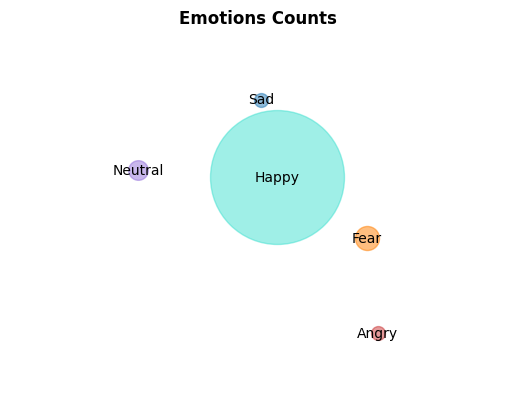

In [48]:
import matplotlib.pyplot as plt

# Create a sample dataset
emotions = emotions_counts['emotion']
counts = emotions_counts['count']
sizes = [count*100 for count in counts] # Scale the size of bubbles based on counts

# Determine the position and color of each bubble
pos = np.random.rand(len(emotions), 2)*5 #scales distance between bubbles
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']
colors = [cb_palette[i] for i in range(len(emotions))]

# Create a figure and axis object
fig, ax = plt.subplots()

# Create the scatter plot using scatter method
for i in range(len(emotions)):
    ax.scatter(x=pos[i, 0], y=pos[i, 1], s=sizes[i], alpha=0.5, color=colors[i])

# Add labels to each bubble
for i in range(len(emotions)):
    ax.annotate(emotions[i], (pos[i, 0], pos[i, 1]), ha='center', va='center')

# Customize the layout
ax.set_title('Emotions Counts', fontweight='bold')
ax.set_xlim(pos[:, 0].min()-1, pos[:, 0].max()+1) # Set x-axis limits to fit the bubbles
ax.set_ylim(pos[:, 1].min()-1, pos[:, 1].max()+1) # Set y-axis limits to fit the bubbles
ax.axis('off') # Remove the axis

# Show the plot
plt.show()


In [49]:
df_plotting

,pos_sec,frame,emotion,probability,moving_avg
0,0.00,1,Angry,0.004754,NaN
1,0.04,2,Angry,0.006010,NaN
2,0.08,3,Angry,0.003043,NaN
3,0.12,4,Angry,0.005749,NaN
4,0.17,5,Angry,0.004518,NaN
...,...,...,...,...,...
702,4.04,98,Neutral,0.076397,0.060849
703,4.08,99,Neutral,0.054596,NaN
704,4.12,100,Neutral,0.041396,NaN
705,4.17,101,Neutral,0.034057,NaN


In [50]:


# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create a trace for each emotion
emotions = df_plotting['emotion'].unique()
traces = []
for i, emotion in enumerate(emotions):
    trace = go.Scatter3d(
        x=df_plotting.loc[df_plotting['emotion'] == emotion, 'pos_sec'],
        y=df_plotting.loc[df_plotting['emotion'] == emotion, 'probability'],
        z=df_plotting.loc[df_plotting['emotion'] == emotion, 'frame'],
        mode='lines+markers',
        name=emotion,
        line=dict(color=cb_palette[i % len(cb_palette)]),
        marker=dict(color=cb_palette[i % len(cb_palette)])
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title=dict(
        text='<b>Emotions Over Time</b>',
        x=0.5,
        y=0.9
    ),
    scene=dict(
        xaxis=dict(title='Time (seconds)'),
        yaxis=dict(title='Probability'),
        zaxis=dict(title='Frame')
    )
)

# Create the plot
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()




In [51]:

# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create the violin plot
fig = px.violin(df_plotting, x='emotion', y='probability', color='emotion', box=True, points='all', 
                color_discrete_sequence=cb_palette)

# Update the layout of the plot
fig.update_layout(
    title=dict(
        text='<b>Emotions Probability Distribution</b>',
        x=0.5,
        y=0.9
    ),
    xaxis=dict(title='Emotion'),
    yaxis=dict(title='Probability')
)

# Show the plot
fig.show()


In [52]:
import plotly.graph_objs as go
import numpy as np

# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Define the data
t = np.linspace(0, 10, 100)
x = np.sin(t)
y = np.cos(t)
z = np.random.rand(100)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,
        colorscale=cb_palette,
        opacity=0.8
    ),
    hovertemplate='<b>Emotion:</b> %{text}<br><b>Time:</b> %{x:.2f} s<br><b>Probability:</b> %{y:.2f}<extra></extra>',
    text=['Happiness']*20 + ['Anger']*20 + ['Surprise']*20 + ['Sadness']*20 + ['Disgust']*20
)])

# Update the layout
fig.update_layout(
    title=dict(
        text='Emotions Over Time',
        x=0.5,
        y=0.9,
        font=dict(
            size=28
        )
    ),
    scene=dict(
        xaxis=dict(title='Time (seconds)', range=[-1.1, 1.1]),
        yaxis=dict(title='Probability', range=[-1.1, 1.1]),
        zaxis=dict(title='Emotion'),
        aspectratio=dict(x=1, y=1, z=0.4)
    ),
    font=dict(
        size=18
    ),
    hoverlabel=dict(
        bgcolor='white',
        font=dict(
            size=16
        )
    )
)

# Show the plot
fig.show()


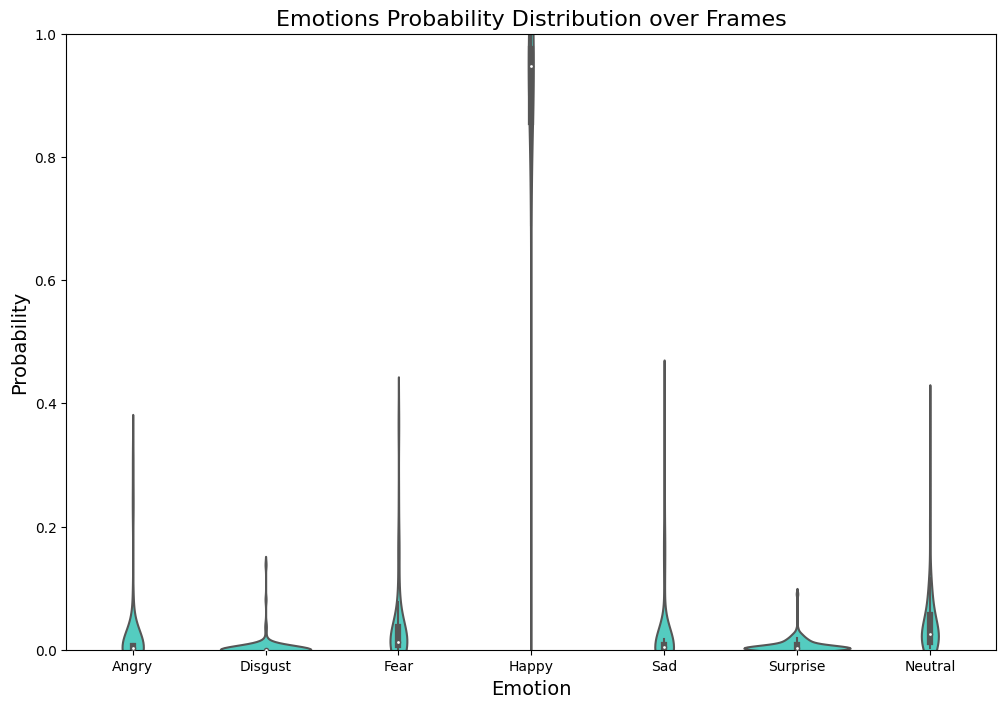

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create the violin plot
sns.violinplot(data=df_plotting, x='emotion', y='probability', color=cb_palette[0], ax=ax)

# Set the axis labels and title
ax.set_xlabel('Emotion', fontsize=14)
ax.set_ylabel('Probability', fontsize=14)
ax.set_title('Emotions Probability Distribution over Frames', fontsize=16)

# Set the y-axis limits
ax.set_ylim([0, 1])

# Show the plot
plt.show()


In [ ]:
df_plotting

(707, 5)

In [ ]:
from paz.pipelines import MiniXceptionFER

classify = MiniXceptionFER()

ModuleNotFoundError: No module named 'paz'

In [54]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Group the DataFrame by emotion and frame, and count the number of occurrences
df_counts = df_plotting.groupby(['emotion', 'frame'])['probability'].sum().reset_index()

# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create a trace for each emotion
emotions = df_counts['emotion'].unique()
traces = []
for i, emotion in enumerate(emotions):
    trace = go.Scatter3d(
        x=df_counts.loc[df_counts['emotion'] == emotion, 'frame'],
        y=np.full(len(df_counts.loc[df_counts['emotion'] == emotion]), i),
        z=df_counts.loc[df_counts['emotion'] == emotion, 'probability'],
        mode='markers',
        name=emotion,
        marker=dict(size=5, color=cb_palette[i % len(cb_palette)], opacity=0.8)
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title=dict(
        text='<b>Emotions Count over Frames</b>',
        x=0.5,
        y=0.9
    ),
    scene=dict(
        xaxis=dict(title='Frame'),
        yaxis=dict(title='Emotion'),
        zaxis=dict(title='probability')
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Create the plot
fig = go.Figure(data=traces, layout=layout)

# Show the plot
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Group the DataFrame by emotion and frame, and sum the probabilities
df_sum = df_plotting.groupby(['emotion', 'frame'])['probability'].sum().reset_index()

# Create a new DataFrame with one row per emotion and one column per frame
df_pivot = df_sum.pivot(index='emotion', columns='frame', values='probability').fillna(0)

# Define the color palette
cb_palette = ['#40E0D0', '#ff7f00', '#9370DB', '#CA3435', '#1f77b4', '#9467bd', '#7f7f7f']

# Create the treemap plot
fig = px.treemap(
    df_pivot,
    path=[df_pivot.index.name, df_pivot.columns.name],
    values=df_pivot.values.flatten(),
    color=df_pivot.values.flatten(),
    color_continuous_scale=cb_palette,
    color_continuous_midpoint=0.5,
    hover_data='frame',
    title='Emotions Distribution over Time'
)

# Update the layout of the plot
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    coloraxis=dict(
        colorbar=dict(
            thicknessmode='pixels',
            thickness=20,
            lenmode='pixels',
            len=300,
            yanchor='middle',
            y=0.5,
            ticks='outside',
            tickmode='auto',
            nticks=len(cb_palette),
            tickcolor='white',
            ticklen=10,
            tickfont=dict(color='white', size=12)
        )
    )
)

# Show the plot
fig.show()


ValueError: Value of 'path_0' is not the name of a column in 'data_frame'. Expected one of [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102] but received: emotion

In [ ]:
df_pivot

frame,1,2,3,4,5,6,7,8,9,10,...,91,94,95,96,97,98,99,100,101,102
emotion,,,,,,,,,,,,,,,,,,,,,
Angry,0.004754,0.006010,0.003043,0.005749,0.004518,0.014398,0.003394,0.022420,0.015442,0.005769,...,0.041053,0.244846,0.328220,0.303392,0.300839,0.289484,0.234961,0.194934,0.095574,0.082408
Disgust,0.000016,0.000016,0.000011,0.000046,0.000030,0.000109,0.000015,0.000085,0.000022,0.000012,...,0.008117,0.009602,0.007879,0.138256,0.011815,0.018421,0.081808,0.041353,0.010777,0.007125
Fear,0.006978,0.027883,0.014361,0.030709,0.025148,0.064432,0.008064,0.058179,0.098677,0.048737,...,0.177331,0.367178,0.344638,0.076776,0.419593,0.383211,0.072381,0.046578,0.100690,0.065259
Happy,0.937312,0.762690,0.899901,0.862432,0.852247,0.770944,0.937469,0.734867,0.804541,0.869642,...,0.368663,0.053302,0.045615,0.218199,0.405665,0.037615,0.380906,0.466949,0.471336,0.568956
Neutral,0.042770,0.182112,0.072687,0.077915,0.104629,0.106470,0.046448,0.155238,0.050580,0.062350,...,0.214077,0.083138,0.095111,0.096000,0.108087,0.076397,0.054596,0.041396,0.034057,0.019707
Sad,0.003946,0.009061,0.004817,0.006436,0.008460,0.033075,0.002114,0.018430,0.007662,0.006872,...,0.176513,0.224530,0.165389,0.153402,0.730580,0.177390,0.141223,0.192358,0.270419,0.251325
Surprise,0.004224,0.012228,0.005181,0.016714,0.004969,0.010573,0.002497,0.010781,0.023076,0.006617,...,0.014245,0.017403,0.013148,0.013976,0.023421,0.017482,0.034125,0.016432,0.017146,0.005220


In [ ]:
emotion_categories= {
            0: "angry",
            1: "disgust",
            2: "fear",
            3: "happy",
            4: "sad",
            5: "surprise",
            6: "neutral",
        }

In [ ]:
# Display the first image in the results list
plt.imshow(results[66], cmap='gray')
plt.show()

NameError: name 'results' is not defined

Old / not yet used

In [ ]:

    
    # Loop through each detected face and perform emotion detection
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        emotion_preds = DeepFace.analyze(face_img, actions=["emotion"])
        emotion_dict = emotion_preds["emotion"]

        #labels for plotting on video
        emotion_label = max(emotion_preds["emotion"].items(), key=lambda x: x[1])  # get the label with the highest probability
        cv2.putText(frame, emotion_label[0], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Add the timestamp and emotion probabilities to the dataframe
        timestamp = frame_count / video.get(cv2.CAP_PROP_FPS)
        row = {'timestamp': timestamp, 'emotion': emotion_dict}
        df = df.append(row, ignore_index=True)
        
        # Draw a rectangle around the face and display the dominant emotion
        emotion_label = max(emotion_dict.items(), key=lambda x: x[1])[0]
        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Show the frame with the detected faces and emotions
    cv2.imshow("Emotion Detection", frame)
    if cv2.waitKey(1) == ord("q"):
        break

# Release the video and close the window
video.release()
cv2.destroyAllWindows()

# Print the dataframe
print(df)

ValueError: Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.